# Imports

In [69]:
from sklearn.datasets import make_moons
from sklearn.utils import Bunch
import torch as th
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm

# Parameters / Magic Numbers

In [70]:
SEED = 0
NUM_SAMPLES = 300
NOISE = 0.05
NUM_EPOCHS = 1000
TRAIN_TEST_SPLIT_RATIO = 0.8
LEARNING_RATE = 4e-3
RESOLUTION = 10
HIDDEN_DIM = 32
NUM_LAYERS = 4
TQDM_NCOLS = 150
TQDM_UPDATE_FREQUENCY = 10


# NAMs in PyTorch

In [71]:
# define the Neural Additive Model for 2D inputs only without the 1D submodules
class NAM2DOnly(th.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(NAM2DOnly, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.submodules = th.nn.ModuleList()
        
        # initialize the 2D submodules
        for i, j in combinations(range(input_dim), 2):
            submodule = self.create_submodule(num_layers, hidden_dim, output_dim, input_size=2)
            self.submodules.append(submodule)
    
    # TODO make the submodule architecture a parameter
    def create_submodule(self, num_layers, hidden_dim, output_dim, input_size=1):
        submodule = th.nn.Sequential()
        for l in range(num_layers):
            if l == 0:
                submodule.add_module(f"linear_{l}", th.nn.Linear(input_size, hidden_dim))
            else:
                submodule.add_module(f"linear_{l}", th.nn.Linear(hidden_dim, hidden_dim))
            submodule.add_module(f"ELU_{l}", th.nn.ELU())
            # TODO make this optional as a parameter
            submodule.add_module(f"dropout_{l}", th.nn.Dropout(0.5))
        submodule.add_module(f"linear_{num_layers}", th.nn.Linear(hidden_dim, output_dim))
        return submodule

    def forward(self, x):
        output = th.zeros(x.shape[0], self.output_dim)
        
        # process 2D submodules
        submodule_idx = 0
        for i, j in combinations(range(self.input_dim), 2):
            output += self.submodules[submodule_idx](x[:, [i, j]])
            submodule_idx += 1

        return th.nn.functional.softmax(output, dim=1)
    
    def init_weights(self, m):
        if type(m) == th.nn.Linear:
            th.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    # output what each submodule predicts for each input between 0 and 1 for a given resolution
    def get_feature_maps(self, resolution=100):
        # initialize output tensors
        output_2D = th.zeros(self.input_dim * (self.input_dim - 1) // 2, resolution, resolution, self.output_dim)

        # process 2D submodules
        submodule_idx = 0
        pair_idx = 0
        for i, j in combinations(range(self.input_dim), 2):
            for k in range(resolution):
                for l in range(resolution):
                    input_values = th.tensor([[k / (resolution - 1), l / (resolution - 1)]]).float()
                    output_2D[pair_idx, k, l] = self.submodules[submodule_idx](input_values)
            pair_idx += 1
            submodule_idx += 1

        # return output as numpy arrays
        return output_2D.detach().numpy()



# define the Neural Additive Model
class NAM2D1D(th.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(NAM2D1D, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.submodules = th.nn.ModuleList()
        
        # initialize the 1D submodules
        for i in range(input_dim):
            submodule = self.create_submodule(num_layers, hidden_dim, output_dim)
            self.submodules.append(submodule)

        # initialize the 2D submodules
        for i, j in combinations(range(input_dim), 2):
            submodule = self.create_submodule(num_layers, hidden_dim, output_dim, input_size=2)
            self.submodules.append(submodule)
    
    # TODO make the submodule architecture a parameter
    def create_submodule(self, num_layers, hidden_dim, output_dim, input_size=1):
        submodule = th.nn.Sequential()
        for l in range(num_layers):
            if l == 0:
                submodule.add_module(f"linear_{l}", th.nn.Linear(input_size, hidden_dim))
            else:
                submodule.add_module(f"linear_{l}", th.nn.Linear(hidden_dim, hidden_dim))
            submodule.add_module(f"ELU_{l}", th.nn.ELU())
            # TODO make this optional as a parameter
            # submodule.add_module(f"dropout_{l}", th.nn.Dropout(0.5))
        submodule.add_module(f"linear_{num_layers}", th.nn.Linear(hidden_dim, output_dim))
        return submodule

    def forward(self, x):
        output = th.zeros(x.shape[0], self.output_dim)
        
        # process 1D submodules
        for i in range(self.input_dim):
            output += self.submodules[i](x[:, i].unsqueeze(1))
        
        # process 2D submodules
        submodule_idx = self.input_dim
        for i, j in combinations(range(self.input_dim), 2):
            output += self.submodules[submodule_idx](x[:, [i, j]])
            submodule_idx += 1

        return th.nn.functional.softmax(output, dim=1)
    
    def init_weights(self, m):
        if type(m) == th.nn.Linear:
            th.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    # output what each submodule predicts for each input between 0 and 1 for a given resolution
    def get_feature_maps(self, resolution=100):
        # initialize output tensors
        output_1D = th.zeros(self.input_dim, resolution, self.output_dim)
        output_2D = th.zeros(self.input_dim * (self.input_dim - 1) // 2, resolution, resolution, self.output_dim)

        # process 1D submodules
        for i in range(self.input_dim):
            for j in range(resolution):
                input_value = th.tensor([[j / (resolution - 1)]]).float()
                output_1D[i, j] = self.submodules[i](input_value)

        # process 2D submodules
        submodule_idx = self.input_dim
        pair_idx = 0
        for i, j in combinations(range(self.input_dim), 2):
            for k in range(resolution):
                for l in range(resolution):
                    input_values = th.tensor([[k / (resolution - 1), l / (resolution - 1)]]).float()
                    output_2D[pair_idx, k, l] = self.submodules[submodule_idx](input_values)
            pair_idx += 1
            submodule_idx += 1

        # return output as numpy arrays
        return output_1D.detach().numpy(), output_2D.detach().numpy()
    
    def permuted_forward_pass_2D(X, i, j, random_state=0):
        """
        Same as forward pass but when the submodule which processes the pair (i, j) is called, the data is permuted at the features i and j using the random_state.

        Parameters:
            X: input data
            i: the first feature (the combination with j is permuted)
            j: the second feature (the combination with i is permuted)
            random_state: the seed to use for the permutation

        returns:
            the output of the network
        """
        # TODO
        pass
    
    def get_importance_2D(X, y, i, j, n_repeats=30, random_state=0):
        """
        Return the importance of the 2D submodule for the pair (i, j).
        The forward pass is called without permutation on the dataset first.
        Then we call a forward pass with permutation on the dataset where when the part of the architecture is called where features i and j are processed, the data is permuted.
        We take the ratio of original error / permuted error and repeat the cycle n_repeats times to average the importance.

        Parameters:
            X: input data
            y: labels
            i: the first feature (the combination with j is permuted)
            j: the second feature (the combination with i is permuted)
            n_repeats: the number of times to repeat the permutation
            random_state: the seed to use for the permutation

        returns:
            The importance of the 2D submodule for the pair (i, j)
        """
        # TODO
        pass

    def permuted_forward_pass_1D(X, i, random_state=0):
        """
        Same as forward pass but when the submodule which processes the feature i is called, the data is permuted at the feature i using the random_state.

        Parameters:
            X: input data
            i: the feature (i is permuted)
            random_state: the seed to use for the permutation

        returns:
            the output of the network
        """
        # TODO
        pass

    def get_importance_1D(X, y, i, n_repeats=30, random_state=0):
        """
        Return the importance of the 1D submodule for the feature i.
        The forward pass is called without permutation on the dataset first.
        Then we call a forward pass with permutation on the dataset where when the part of the architecture is called where feature i is processed, the data is permuted.
        We take the ratio of original error / permuted error and repeat the cycle n_repeats times to average the importance.

        Parameters:
            X: input data
            y: labels
            i: the feature (i is permuted)
            n_repeats: the number of times to repeat the permutation
            random_state: the seed to use for the permutation

        returns:
            The importance of the 1D submodule for the feature i
        """
        # TODO
        pass



# define the Neural Additive Model
class NAM(th.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        # for each input dimension, we have an individual network with num_layers layers
        # the output of the overall network is the sum of the outputs of the individual networks, fed into a softmax for classification
        super(NAM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.submodules = th.nn.ModuleList()
        # initialize the submodules and make sure they accept input dimension = 1 for the first layer and hidden_dim for all other layers. they should have num_layers layers and output_dim output dimensions
        # also use dropout with p=0.5
        for i in range(input_dim):
            # initialize the submodule
            submodule = th.nn.Sequential()
            for l in range(num_layers):
                if l == 0:
                    submodule.add_module(f"linear_{l}", th.nn.Linear(1, hidden_dim))
                else:
                    submodule.add_module(f"linear_{l}", th.nn.Linear(hidden_dim, hidden_dim))
                submodule.add_module(f"ELU_{l}", th.nn.ELU())
                submodule.add_module(f"dropout_{l}", th.nn.Dropout(0.5))
            # each subnetwork has a final linear layer to output the final output
            submodule.add_module(f"linear_{num_layers}", th.nn.Linear(hidden_dim, output_dim))
            # add the submodule to the list of submodules
            self.submodules.append(submodule)
                        
    
    def forward(self, x):
        """
        The forward pass passes each input dimension through the corresponding submodule and sums over their outputs. The output is then fed into a softmax for classification.
        """
        # initialize the output
        output = th.zeros(x.shape[0], self.output_dim)
        # for each input dimension, pass it through the corresponding submodule and add the output to the overall output
        for i in range(self.input_dim):
            output += self.submodules[i](x[:,i].unsqueeze(1))
        # return the softmax of the output
        return th.nn.functional.softmax(output, dim=1)

    def init_weights(self, m):
        if type(m) == th.nn.Linear:
            th.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    # output what each submodule predicts for each input between 0 and 1 for a given resolution
    def get_feature_maps(self, resolution=100):
        # initialize the output
        output = th.zeros(resolution, self.input_dim, self.output_dim)
        # for each input dimension, pass it through the corresponding submodule and add the output to the overall output
        for i in range(self.input_dim):
            for j in range(resolution):
                output[j,i] = self.submodules[i](th.tensor([[j/resolution]]))
        # return output as numpy array
        return np.moveaxis(output.detach().numpy(), 0, -1)

# Function Definitions

In [72]:
def create_sklearn_dataset(X, y, feature_names, target_names):
    return Bunch(data=X,
                 target=y,
                 feature_names=feature_names,
                 target_names=target_names)


def normalize_data(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


def train(model, X, y, optimizer, loss_fn):
    model.train()
    X = th.tensor(X, dtype=th.float32)
    y = th.tensor(y, dtype=th.long)
    optimizer.zero_grad()
    output = model(X)
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, X, y, loss_fn):
    model.eval()
    X = th.tensor(X, dtype=th.float32)
    y = th.tensor(y, dtype=th.long)
    output = model(X)
    loss = loss_fn(output, y)
    accuracy = (output.argmax(dim=1) == y).sum().item() / y.shape[0]
    return loss.item(), accuracy


def revert_normalization(feature_maps, data_min, data_range):
    for i in range(feature_maps.shape[-1]):
        feature_maps[..., i] = feature_maps[..., i] * data_range[i] + data_min[i]
    return feature_maps


# Data

### Loading the Data

In [73]:
X, y = make_moons(n_samples=NUM_SAMPLES, noise=NOISE, random_state=SEED)
num_features = X.shape[1]
output_dim = len(np.unique(y))
input_ranges = np.zeros((num_features, 2))
for i in range(num_features):
    input_ranges[i, 0] = np.min(X[:, i])
    input_ranges[i, 1] = np.max(X[:, i])

feature_names = ['x', 'y']
target_names = ['Class 0', 'Class 1']

sklearn_dataset = create_sklearn_dataset(X, y, feature_names, target_names)


### Plotting the Data

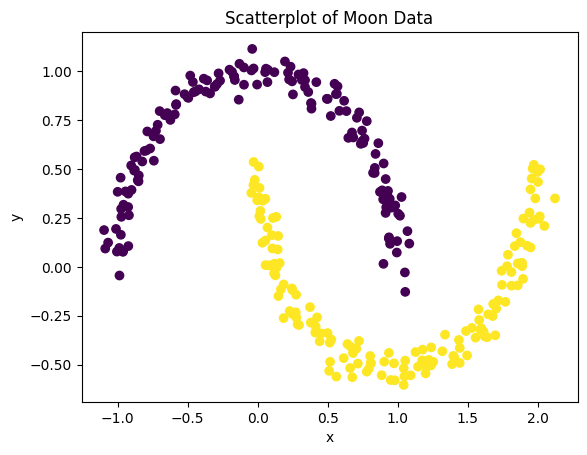

In [74]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Scatterplot of Moon Data')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.show()


### Preprocessing

In [75]:
X = normalize_data(X)

output_class_dict = {i: sklearn_dataset.target_names[i] for i in range(len(sklearn_dataset.target_names))}
feature_dict = {i: sklearn_dataset.feature_names[i] for i in range(len(sklearn_dataset.feature_names))}

train_size = int(TRAIN_TEST_SPLIT_RATIO * X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]


# Model Definition and Training

In [76]:
from tqdm import tqdm

model = NAM2D1D(input_dim=num_features, hidden_dim=HIDDEN_DIM, output_dim=output_dim, num_layers=NUM_LAYERS)

th.manual_seed(SEED)
np.random.seed(SEED)
model.apply(model.init_weights)

# print(model)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = F.cross_entropy

# Create a tqdm progress bar
progress_bar = tqdm(range(NUM_EPOCHS), desc="Training progress", ncols=TQDM_NCOLS)

for epoch in progress_bar:
    train_loss = train(model, X_train, y_train, optimizer, loss_fn)
    test_loss, test_accuracy = evaluate(model, X_test, y_test, loss_fn)
    
    # Update the progress bar description less frequently (every update_frequency epochs)
    if epoch % TQDM_UPDATE_FREQUENCY == 0:
        progress_bar.set_description(f'Epoch {epoch+1}: train loss = {train_loss:.4f}, test loss = {test_loss:.4f}, test accuracy = {test_accuracy:.4f}')

print(f'Final test accuracy: {test_accuracy:.4f}')


Epoch 991: train loss = 0.3133, test loss = 0.3133, test accuracy = 1.0000: 100%|████████████████████████████████| 1000/1000 [00:06<00:00, 148.76it/s]

Final test accuracy: 1.0000


# Feature Maps and Visualization

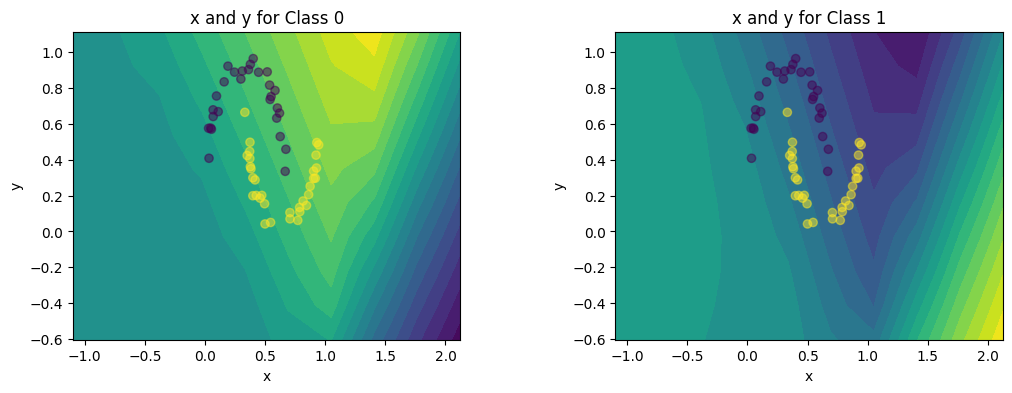

In [78]:
feature_maps_1D, feature_maps_2D = model.get_feature_maps(resolution=RESOLUTION)

data_min = X.min(axis=0)
data_range = X.max(axis=0) - data_min

# feature_maps_1D = revert_normalization(feature_maps_1D, data_min, data_range)
# feature_maps_2D = revert_normalization(feature_maps_2D, data_min, data_range)

num_pairs, _, _, num_classes = feature_maps_2D.shape
pair_indices = list(combinations(range(num_features), 2))

fig, axs = plt.subplots(num_pairs, num_classes, figsize=(12, 4 * num_pairs), squeeze=False)
for pair_idx, (i, j) in enumerate(pair_indices):
    for output_feature in range(num_classes):
        x = np.linspace(input_ranges[i, 0], input_ranges[i, 1], RESOLUTION)
        y = np.linspace(input_ranges[j, 0], input_ranges[j, 1], RESOLUTION)
        X, Y = np.meshgrid(x, y)
        Z = feature_maps_2D[pair_idx, :, :, output_feature].T

        target_class = output_feature
        im = axs[pair_idx, output_feature].contourf(X, Y, Z, cmap='viridis', levels=20)
        axs[pair_idx, output_feature].scatter(X_test[:, i], X_test[:, j], c=y_test, alpha=0.5, cmap='viridis')
        axs[pair_idx, output_feature].set_title(f'{feature_dict[i]} and {feature_dict[j]} for {output_class_dict[output_feature]}')

        axs[pair_idx, output_feature].set_xlabel(feature_dict[i])
        axs[pair_idx, output_feature].set_ylabel(feature_dict[j])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.6)
plt.show()
